In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

import time
import os
import copy

# Logging time, process
from tqdm import tqdm


class VGG11(torch.nn.Module):
    '''
        https://www.kaggle.com/pytorch/vgg11
    '''
    
    def __init__(self):
        super().__init__()
        
        self.conv1_1 = torch.nn.Conv2d(in_channels = 3, 
                                       out_channels = 64, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
    
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        
        self.conv2_1 = torch.nn.Conv2d(in_channels = 64, 
                                       out_channels = 128, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        self.conv3_1 = torch.nn.Conv2d(in_channels = 128, 
                                       out_channels = 256, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.conv3_2 = torch.nn.Conv2d(in_channels = 256, 
                                       out_channels = 256, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.pool3 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        self.conv4_1 = torch.nn.Conv2d(in_channels = 256, 
                                       out_channels = 512, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.conv4_2 = torch.nn.Conv2d(in_channels = 512, 
                                       out_channels = 512, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.pool4 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        self.conv5_1 = torch.nn.Conv2d(in_channels = 512, 
                                       out_channels = 512, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.conv5_2 = torch.nn.Conv2d(in_channels = 512, 
                                       out_channels = 512, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.pool5 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        self.fc1 = torch.nn.Linear(512*7*7, 4096)
        self.fc2 = torch.nn.Linear(4096, 4096)
        self.fc3 = torch.nn.Linear(4096, 1000)
        
        
    def forward(self, x):
        
        x = F.relu(self.conv1_1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2_1(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.pool4(x)
        
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = self.pool5(x)
        
        # Flatten CNN output to feed to the fully-connected layer
        x = x.view(-1, 512*7*7)
        
        # Use ReLU activation for first FC layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output with 10 classes, use log_softmax
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return(x)

In [ ]:
checkpoint = torch.load("data/vgg11.pth")
layer_mapping = {
    'features.0.weight': 'conv1_1.weight', 'features.0.bias': 'conv1_1.bias',
    'features.3.weight': 'conv2_1.weight', 'features.3.bias': 'conv2_1.bias',
    'features.6.weight': 'conv3_1.weight', 'features.6.bias': 'conv3_1.bias',
    'features.8.weight': 'conv3_2.weight', 'features.8.bias': 'conv3_2.bias',
    'features.11.weight': 'conv4_1.weight', 'features.11.bias': 'conv4_1.bias',
    'features.13.weight': 'conv4_2.weight', 'features.13.bias': 'conv4_2.bias',
    'features.16.weight': 'conv5_1.weight', 'features.16.bias': 'conv5_1.bias',
    'features.18.weight': 'conv5_2.weight', 'features.18.bias': 'conv5_2.bias',
    'classifier.0.weight': 'fc1.weight', 'classifier.0.bias': 'fc1.bias',
    'classifier.3.weight': 'fc2.weight', 'classifier.3.bias': 'fc2.bias',
    'classifier.6.weight': 'fc3.weight', 'classifier.6.bias': 'fc3.bias',
}

import collections
converted_state = collections.OrderedDict()
for layer in layer_mapping:
    converted_state[layer_mapping[layer]] = checkpoint[layer]

In [ ]:
model = VGG11()
model.load_state_dict(converted_state)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset = datasets.ImageFolder("data/cat_dog", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
data_label_mapping = dataset.class_to_idx
data_label_mapping = {data_label_mapping[label]: label for label in data_label_mapping}

In [ ]:
import json
with open('data/imagenet1000_clsidx_to_labels.json', ) as f:
    imnet_label_mapping = json.load(f)
    imnet_label_mapping = {int(label): imnet_label_mapping[label] for label in imnet_label_mapping}

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

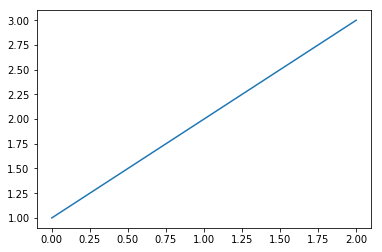

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig = plt.figure()
ax = fig.add_subplot(111)
x, y = 10*np.random.rand(2, 1000)
ax.plot([1, 2, 3])  # plot some data in data coordinates

# circ = patches.Circle((0.5, 0.5), 0.25, transform=ax.transAxes,
#                       facecolor='yellow', alpha=0.5)
# ax.add_patch(circ)

plt.show()

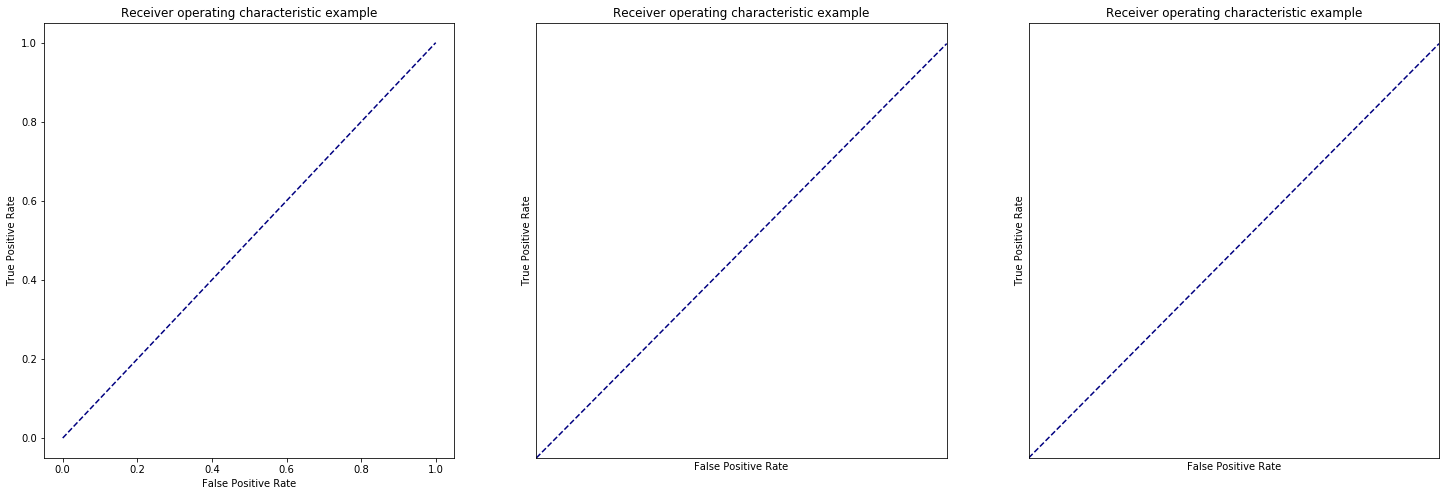

In [6]:
import matplotlib.pyplot as plt

plt.clf()

fig = plt.figure(figsize=(25, 8))
ax = fig.add_subplot(1, 3, 1)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
plt.show()

In [ ]:
fig = plt.figure(figsize=(25, 8))

for idx, data in enumerate(dataloader):
    image, label = data
    with torch.no_grad():
        model.eval()
        log_ps = model(image)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1) # Get top 1 class
        
        ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
        image = inv_normalize(image[0])
        image = image.numpy().transpose((1, 2, 0))
        plt.imshow(image)
        ax.set_title("{} ({})".format(data_label_mapping[int(label)], imnet_label_mapping[int(top_class)]))
            